In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [ ]:
import yfinance as yf
import pandas as pd

UNIVERSE = [
    'AAPL', 'MSFT', 'GOOG', 'PLTR', 'AMZN', 'META', 'TSLA', 'NVDA', 'NFLX', 'INTC', 'AMD',
    'ORCL', 'CSCO', 'ADBE', 'CRM', 'QCOM', 'TXN', 'AVGO', 'IBM', 'MU', 'AMAT',
    'PYPL', 'SHOP', 'UBER', 'SNAP', 'ZM', 'BIDU', 'JD', 'PDD', 'COIN'
]
START = '2019-01-01'
END = '2024-12-31'

# Download data
tickers = UNIVERSE + ['BTC-USD']
data = yf.download(tickers, start=START, end=END)['Close']

# Drop columns (tickers) with all NaNs (failed downloads)
data = data.dropna(axis=1, how='all')

# Print which tickers are missing
missing = set(tickers) - set(data.columns)
if missing:
    print(f"Warning: The following tickers failed to download and will be skipped: {missing}")

# Forward and backward fill missing data
data = data.ffill().bfill()

# Continue only if 'BTC-USD' is present
if 'BTC-USD' not in data.columns:
    raise ValueError("'BTC-USD' benchmark data is missing. Please check Yahoo Finance or try again later.")

# Compute log returns
returns = np.log(data / data.shift(1)).dropna()
btc_returns = returns['BTC-USD']
returns = returns.drop(columns=['BTC-USD'])

/tmp/ipython-input-2-567636674.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START, end=END)['Close']
[*********************100%***********************]  31 of 31 completed


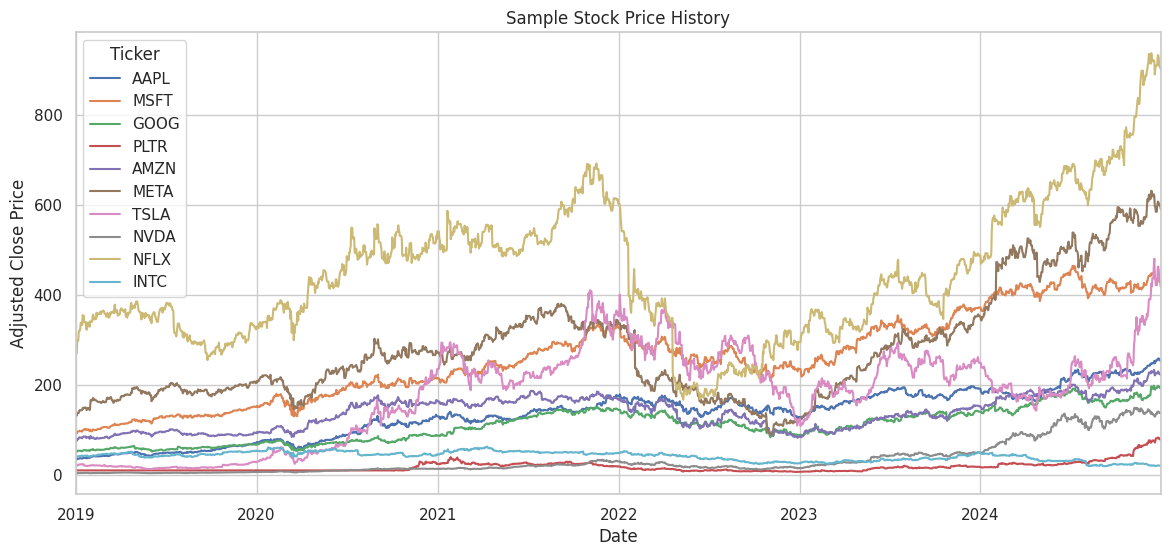

In [ ]:
plt.figure(figsize=(14, 6))
data[UNIVERSE[:10]].plot(ax=plt.gca())
plt.title("Sample Stock Price History")
plt.ylabel("Adjusted Close Price")
plt.show()

**Pairs Trading**

**Systematic Pairs Selection**

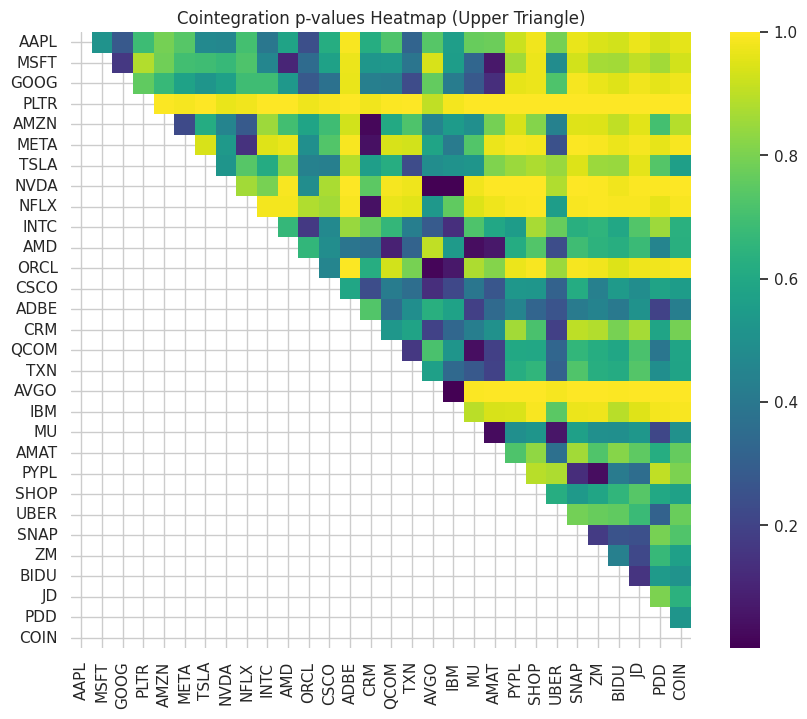

Found 11 cointegrated pairs.


In [ ]:
def find_cointegrated_pairs(data, pval_threshold=0.05):
    n = data.shape[1]
    pairs = []
    pval_matrix = np.ones((n, n))
    for i in range(n):
        for j in range(i+1, n):
            score, pvalue, _ = coint(data.iloc[:, i], data.iloc[:, j])
            pval_matrix[i, j] = pvalue
            if pvalue < pval_threshold:
                pairs.append((data.columns[i], data.columns[j], pvalue))
    return pairs, pval_matrix

pairs, pval_matrix = find_cointegrated_pairs(data[UNIVERSE])

# Create a mask for the lower triangle and diagonal
mask = np.tril(np.ones_like(pval_matrix, dtype=bool))

# Visualize cointegration p-values (upper triangle only)
plt.figure(figsize=(10, 8))
sns.heatmap(
    pval_matrix,
    xticklabels=UNIVERSE,
    yticklabels=UNIVERSE,
    cmap='viridis',
    annot=False,
    mask=mask  # <--- This hides the lower triangle and diagonal
)
plt.title("Cointegration p-values Heatmap (Upper Triangle)")
plt.show()

print(f"Found {len(pairs)} cointegrated pairs.")

**Select Pairs Based on Correlation Threshold**

In [ ]:
# Calculate correlation matrix
corr_matrix = data[UNIVERSE].corr()

# Correlation threshold (e.g., 0.85)
corr_threshold = 0.85
selected_pairs = []

for i in range(len(UNIVERSE)):
    for j in range(i+1, len(UNIVERSE)):
        if corr_matrix.iloc[i, j] > corr_threshold:
            selected_pairs.append((UNIVERSE[i], UNIVERSE[j]))

print(f"Selected {len(selected_pairs)} pairs with correlation above {corr_threshold}")

Selected 48 pairs with correlation above 0.85


**Calculate Hedge Ratios and Spreads for Each Pair**

In [ ]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

hedge_ratios = {}
spreads = pd.DataFrame(index=data.index)

for stock_a, stock_b in selected_pairs:
    y = data[stock_a]
    x = data[stock_b]
    x_ = add_constant(x)
    model = OLS(y, x_).fit()
    hedge_ratio = model.params[1]
    spread = y - hedge_ratio * x
    hedge_ratios[(stock_a, stock_b)] = hedge_ratio
    spreads[(stock_a, stock_b)] = spread

/tmp/ipython-input-6-3037977881.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
/tmp/ipython-input-6-3037977881.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
/tmp/ipython-input-6-3037977881.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
/tmp/ipython-input-6-3037977881.py:12: FutureWarning: Series.__getitem__ treating keys as p

**Generate Trading signals for all Pairs**

In [ ]:
def zscore(series):
    return (series - series.mean()) / series.std()

signals = pd.DataFrame(index=spreads.index)
entry_z = 2.0
exit_z = 0.5

for pair in spreads.columns:
    zscores = zscore(spreads[pair])
    signal = pd.Series(0, index=zscores.index)
    # Long spread when z < -entry_z, short when z > entry_z, exit when |z| < exit_z
    signal[zscores < -entry_z] = 1    # Long spread
    signal[zscores > entry_z] = -1    # Short spread
    signal[(zscores.abs() < exit_z)] = 0  # Exit
    signal = signal.ffill().fillna(0)     # Maintain position until exit
    signals[pair] = signal

**Calculate Daily Returns for Each Pair**

In [ ]:
pair_returns = pd.DataFrame(index=returns.index)

for (stock_a, stock_b) in signals.columns:
    # Calculate daily spread change
    spread_ret = spreads[(stock_a, stock_b)].diff()
    # Position from previous day
    position = signals[(stock_a, stock_b)].shift(1)
    # P&L: position * change in spread
    pair_returns[(stock_a, stock_b)] = position * spread_ret

# Replace NaNs with 0
pair_returns = pair_returns.fillna(0)

**Aggregate Portfolio Return And Sharpe Ratio**

In [ ]:
# Equally weighted portfolio: sum returns across all pairs, divide by number of pairs
portfolio_returns = pair_returns.sum(axis=1) / len(pair_returns.columns)
portfolio_returns = portfolio_returns.loc[portfolio_returns.index.isin(returns.index)]  # Align with returns index

# Calculate annualized Sharpe Ratio
sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.2f}")

Portfolio Sharpe Ratio: 1.63


**Backtest with Transaction Costs**

In [ ]:
# Set transaction cost (e.g., 0.2% per trade per leg)
TRANSACTION_COST = 0.002

# Initialize DataFrame to store net returns after costs
net_pair_returns = pd.DataFrame(index=pair_returns.index, columns=pair_returns.columns).fillna(0)

# Loop through each pair to apply transaction costs
for pair in pair_returns.columns:
    # Calculate when trades occur (when the signal changes)
    positions = signals[pair]
    trades = positions.diff().abs()  # 1 when entering or exiting a position
    # Transaction cost: cost per trade * price of both legs (approximate with spread price)
    # For simplicity, apply cost on notional value of spread
    spread_price = spreads[pair].abs()  # Use absolute spread as proxy for notional
    cost_per_trade = TRANSACTION_COST * spread_price
    # Apply cost on trade days
    costs = trades * cost_per_trade
    # Net returns: subtract transaction costs from gross returns
    net_pair_returns[pair] = pair_returns[pair] - costs

# Aggregate portfolio returns as before
net_portfolio_returns = net_pair_returns.sum(axis=1) / len(net_pair_returns.columns)
net_portfolio_returns = net_portfolio_returns.loc[net_portfolio_returns.index.isin(returns.index)]

# Calculate Sharpe ratio after costs
net_sharpe_ratio = (net_portfolio_returns.mean() / net_portfolio_returns.std()) * np.sqrt(252)
print(f"Portfolio Sharpe Ratio after transaction costs: {net_sharpe_ratio:.2f}")

Portfolio Sharpe Ratio after transaction costs: 1.56


/tmp/ipython-input-13-225401632.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  net_pair_returns = pd.DataFrame(index=pair_returns.index, columns=pair_returns.columns).fillna(0)


**CSM**

In [4]:
import yfinance as yf
import pandas as pd

UNIVERSE = [
    'AAPL', 'MSFT', 'GOOG', 'PLTR', 'AMZN', 'META', 'TSLA', 'NVDA', 'NFLX', 'INTC', 'AMD',
    'ORCL', 'CSCO', 'ADBE', 'CRM', 'QCOM', 'TXN', 'AVGO', 'IBM', 'MU', 'AMAT',
    'PYPL', 'SHOP', 'UBER', 'SNAP', 'ZM', 'BIDU', 'JD', 'PDD', 'COIN'
]
START = '2019-01-01'
END = '2024-12-31'

# Download data
tickers = UNIVERSE
data = yf.download(tickers, start=START, end=END)['Close']

# Drop columns (tickers) with all NaNs (failed downloads)
data = data.dropna(axis=1, how='all')

# Forward and backward fill missing data
data = data.ffill().bfill()

/tmp/ipython-input-4-1804012785.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START, end=END)['Close']
[*********************100%***********************]  30 of 30 completed


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use the same UNIVERSE and data as in the pairs trading project
# Calculate monthly returns
monthly_prices = data[UNIVERSE].resample('M').last()
monthly_returns = monthly_prices.pct_change().dropna()

/tmp/ipython-input-5-778929017.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = data[UNIVERSE].resample('M').last()


**Momentum Signal Calculation**

In [31]:
LOOKBACK = 18  # months

# Calculate 18-month cumulative returns, shifted to prevent look-ahead
momentum_scores = monthly_prices.pct_change(periods=LOOKBACK).shift(1).dropna()

**Portfolio Construction**

In [32]:
N = len(UNIVERSE)
TOP_N = int(N * 0.1)
BOTTOM_N = int(N * 0.1)

long_returns = []
short_returns = []
dates = []

for date in momentum_scores.index[LOOKBACK:]:
    scores = momentum_scores.loc[date]
    rets = monthly_returns.loc[date]

    # Rank stocks
    top = scores.nlargest(TOP_N).index
    bottom = scores.nsmallest(BOTTOM_N).index

    # Equal-weighted long and short returns
    long_ret = rets[top].mean()
    short_ret = rets[bottom].mean()

    long_returns.append(long_ret)
    short_returns.append(short_ret)
    dates.append(date)

# Convert to pandas Series
long_returns = pd.Series(long_returns, index=dates)
short_returns = pd.Series(short_returns, index=dates)
strategy_returns = long_returns - short_returns

**Visualization**

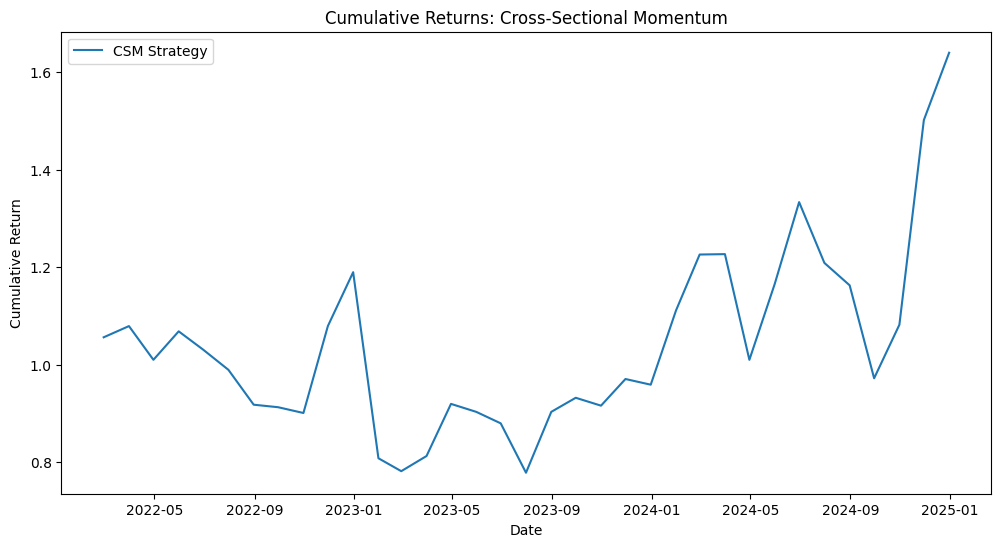

In [33]:
plt.figure(figsize=(12,6))
cumulative = (1 + strategy_returns).cumprod()
plt.plot(cumulative, label='CSM Strategy')
plt.title('Cumulative Returns: Cross-Sectional Momentum')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.show()

**Sharpe Ratio**

In [37]:
sharpe = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(18)
print(f"CSM Strategy Sharpe Ratio (before costs): {sharpe:.2f}")

CSM Strategy Sharpe Ratio (before costs): 0.74


**Backtest with Transaction Costs**

In [40]:
# Calculate portfolio turnover: count how many stocks change in long/short portfolios each month
long_portfolio = []
short_portfolio = []

for date in momentum_scores.index[LOOKBACK:]:
    scores = momentum_scores.loc[date]
    top = set(scores.nlargest(TOP_N).index)
    bottom = set(scores.nsmallest(BOTTOM_N).index)
    long_portfolio.append(top)
    short_portfolio.append(bottom)

turnover = []
for i in range(1, len(long_portfolio)):
    # Stocks entering or leaving the portfolio
    long_changes = len(long_portfolio[i] - long_portfolio[i-1]) + len(long_portfolio[i-1] - long_portfolio[i])
    short_changes = len(short_portfolio[i] - short_portfolio[i-1]) + len(short_portfolio[i-1] - short_portfolio[i])
    turnover.append(long_changes + short_changes)

# First period has no turnover
turnover = [TOP_N + BOTTOM_N] + turnover

# Transaction cost per round trip
transaction_costs = 0.001 * np.array(turnover)
net_strategy_returns = strategy_returns.values - transaction_costs

# Net Sharpe Ratio
net_sharpe = (np.mean(net_strategy_returns) / np.std(net_strategy_returns)) * np.sqrt(12)
print(f"CSM Strategy Sharpe Ratio (after 0.1% costs): {net_sharpe:.2f}")

CSM Strategy Sharpe Ratio (after 0.1% costs): 0.51


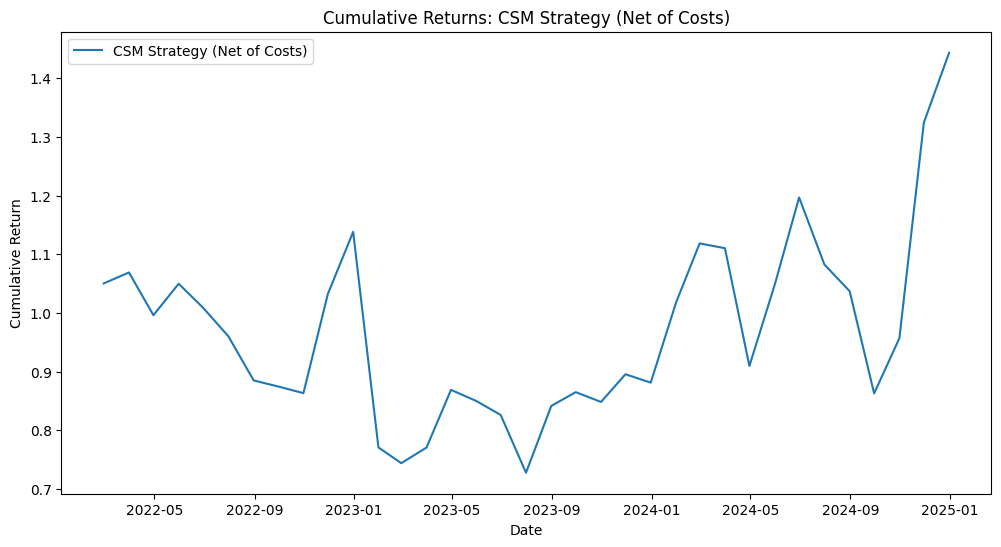

In [39]:
plt.figure(figsize=(12,6))
net_cumulative = np.cumprod(1 + net_strategy_returns)
plt.plot(strategy_returns.index, net_cumulative, label='CSM Strategy (Net of Costs)')
plt.title('Cumulative Returns: CSM Strategy (Net of Costs)')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.show()
